In [ ]:
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [ ]:
#!pip install kaggle


In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/


In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

100% 397M/398M [00:02<00:00, 202MB/s]
100% 398M/398M [00:02<00:00, 189MB/s]


In [ ]:
import zipfile
local_zip = 'face-mask-detection.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall()
zip_ref.close()

In [ ]:
# Считываем данные и посмотрим на картинки
annotation_dir = os.path.join('/content/annotations')
images_dir = os.path.join('/content/images/')
annotations = list(sorted(os.listdir(annotation_dir)))
images = list(sorted(os.listdir(images_dir)))
print(f'Количество наших картинок : {len(images)}')

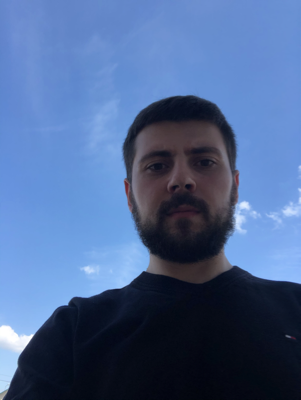

In [ ]:
# Рисуем рандомную картинку из датасета
from google.colab.patches import cv2_imshow
rand_im = random.randint(0, 853)
im = cv2.imread(images_dir + '/' + str(images[rand_im]))
cv2_imshow(im)

In [ ]:
def read_annot(file_name, xml_dir):
    bbox = []
    labels = []
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        else:
            label_idx = 1
        labels.append(label_idx)
        
    return bbox, labels

In [ ]:
def draw_boxes(img, boxes, labels, thickness=1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box, label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # Зеленый
        elif label == 1:
            color = (0,0,225) # Красный
        # Рисование прямоугольника
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, thickness)
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [ ]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir
       
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [ ]:
mask_dataset = image_dataset(images, images_dir, annotation_dir)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader =  DataLoader(mask_dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
num_classes = 3 # 3 класса - фон, без маски, с маской

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Предваритьльно натренированный FastRCNN
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device=device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
param = [i for i in model.parameters() if i.requires_grad]
optimizer = torch.optim.SGD(param, lr=0.01,momentum=0.9, weight_decay=0.0005)
num_epochs = 30
loss_list = []

In [ ]:
for epoch in range(num_epochs):
  print(f' Start training {epoch+1} from {num_epochs}')
  loss_sub_list = []
  for images, targets in mask_loader:
    images = list(img.to(device) for img in images)
    targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
    model.train()

    loss_dict = model(images, targets)
    losses = sum(ls for ls in loss_dict.values())
    loss_value = losses.item()
    loss_sub_list.append(loss_value)
    
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
  
  epoch_loss = np.mean(loss_sub_list)
  loss_list.append(epoch_loss)
  print(f' Epoch loss : {epoch_loss} ')



 Start training 1 from 30


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Epoch loss : 0.39534344754467526 
 Start training 2 from 30
 Epoch loss : 0.274888920778762 
 Start training 3 from 30
 Epoch loss : 0.23742392003117457 
 Start training 4 from 30
 Epoch loss : 0.21066980540700064 
 Start training 5 from 30
 Epoch loss : 0.18925749247051793 
 Start training 6 from 30
 Epoch loss : 0.1727218548799985 
 Start training 7 from 30
 Epoch loss : 0.15524702628232556 
 Start training 8 from 30
 Epoch loss : 0.15778061578735117 
 Start training 9 from 30
 Epoch loss : 0.14464896493558652 
 Start training 10 from 30
 Epoch loss : 0.13909597638601862 
 Start training 11 from 30
 Epoch loss : 0.14081597017163555 
 Start training 12 from 30
 Epoch loss : 0.12449536329916126 
 Start training 13 from 30
 Epoch loss : 0.12039280158469771 
 Start training 14 from 30
 Epoch loss : 0.1095345737521626 
 Start training 15 from 30
 Epoch loss : 0.10608673785579777 
 Start training 16 from 30
 Epoch loss : 0.099662549054333 
 Start training 17 from 30
 Epoch loss : 0.099169

In [ ]:
torch.save(model.state_dict(),'./model_1.pth')

In [ ]:
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    # Выключение BatchNorm и Dropout при предсказании
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    # Приводит тензор к нужному виду    
    test_img = test_img.permute(1,2,0).numpy()
    
    # Делает оптимальный размер ящика
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(), predictions[0]['scores'].cpu(), nm_thrs)
    
    # Показывает только предсказания выше заданного порога
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # Выдает отфильтрованный результат
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


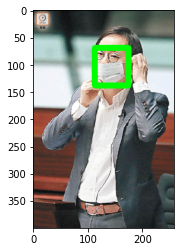

In [ ]:
idx = random.randint(0, len(images))
test_image = Image.open(os.path.join(images_dir, images[idx])).convert('RGB')

test_img, test_boxes, test_labels = single_img_predict(test_image)
test_output = draw_boxes(test_img, test_boxes, test_labels, 10)
plt.imshow(test_output);


In [ ]:
df = Image.open(os.path.join(images_dir, images[idx])).convert('RGB')
df_tens = transforms.ToTensor()(df)
pred = model(df_tens.unsqueeze(0).to(device))
kp_box = torchvision.ops.nms(pred[0]['boxes'].cpu(), pred[0]['scores'].cpu(), 0.3)
kp_box

tensor([0, 1, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


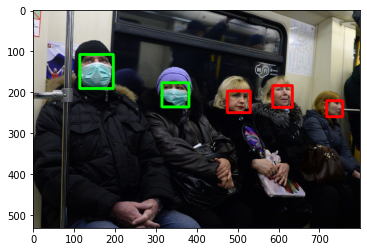

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


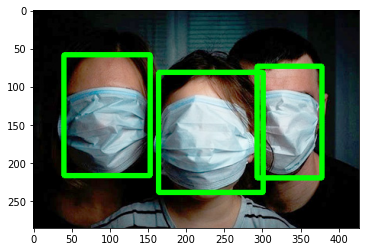

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


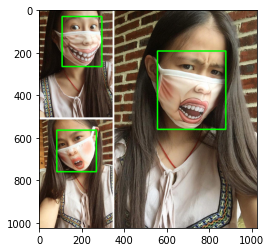

In [ ]:
# Произвольная картинка из инета
img_test = [
            'https://cdn.tvc.ru/pictures/o/397/477.jpg', 
            'https://esoligorsk.by/images/news/soligorsk/2020/april/maska-00.jpg',
            'https://img.joomcdn.net/ad527b7c6193a04fcf94e48825ac5822e1f7d7fd_original.jpeg',                                  
            ]
for img in img_test:
  test_img = Image.open(requests.get(img, stream=True).raw).convert('RGB')

  test_img, test_boxes, test_labels = single_img_predict(test_img)
  test_output = draw_boxes(test_img, test_boxes, test_labels, 5)
  image = cv2.cvtColor(test_output, cv2.COLOR_BGR2HSV )
  plt.imshow(test_output)
  plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


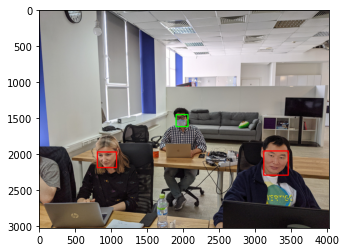

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


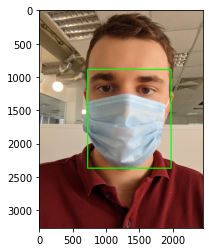

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


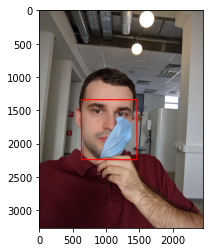

In [ ]:
# фото с телефона
photo_dir = ['/content/Photo-min.jpg', '/content/Photo1-min.jpg', '/content/Photo2.jpg']
for ph in photo_dir:
  test_image = Image.open(ph).convert('RGB')

  test_img, test_boxes, test_labels = single_img_predict(test_image)
  test_output = draw_boxes(test_img, test_boxes, test_labels, 15)
  plt.imshow(test_output)
  plt.show();